# Signal Quality Enhancement in Systematic Trading: A Machine Learning Approach to Refining Technical Indicator Signals

**Dissertation**  
MSc Artificial Intelligence in Finance  
School of Computer Science and Electronic Engineering  
University of Essex  

**Author:** Dulaj Panapitiya  
**Date:** August 2025

## 1. Imports & Setup

Import all required libraries for data processing, technical analysis, machine learning, and visualization.

In [27]:
# === Imports ===
import pandas as pd
import numpy as np

# Technical Analysis library
import ta

# File and OS utilities
import glob
import os

# ML & Visualization
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# LightGBM Classifier
from lightgbm import LGBMClassifier

## 2. Supertrend Indicator Calculation

Function to compute Supertrend indicator and assign trade IDs.

In [28]:
def calculate_supertrend(df_loc):
    """
    Calculate Supertrend indicator and assign position/trade IDs.

    Parameters:
        df_loc (pd.DataFrame): DataFrame containing columns 'prev_high', 'prev_low', 'prev_close'.

    Returns:
        pd.DataFrame: DataFrame with added columns for supertrend, trade_id.
    """

    # Calculate HL2 and ATR(10)
    hl2 = (df_loc['prev_high'] + df_loc['prev_low']) / 2
    atr10 = ta.volatility.AverageTrueRange(high=df_loc['prev_high'], low=df_loc['prev_low'], 
                                           close=df_loc['prev_close'], window=10).average_true_range()

    # Calculate upper and lower bands (Supertrend 10x3)
    upperband = hl2 + (3 * atr10)
    lowerband = hl2 - (3 * atr10) 

    # Initialize arrays for trend, trade ID, and bands
    trend = np.full(len(df_loc), np.nan)
    trend[0] = 1  # Assume uptrend initially

    trade_id = np.full(len(df_loc), np.nan)
    trade_id[0] = 0

    # Main Supertrend calculation loop
    for i in range(1, len(df_loc)):
        curr_close = df_loc['prev_close'].iloc[i]
        prev_close = df_loc['prev_close'].iloc[i - 1]

        # Update trend and bands
        if prev_close < upperband.iloc[i - 1]:
            upperband.iloc[i] = min(upperband.iloc[i], upperband.iloc[i - 1])
        if prev_close > lowerband.iloc[i - 1]:
            lowerband.iloc[i] = max(lowerband.iloc[i], lowerband.iloc[i - 1])

        # Determine trend direction
        if trend[i - 1] == 1:
            trend[i] = 1 if curr_close > lowerband.iloc[i - 1] else -1
        else:
            trend[i] = -1 if curr_close < upperband.iloc[i - 1] else 1

        # Assign trade IDs based on trend change
        if trend[i - 1] == trend[i]:
            trade_id[i] = trade_id[i - 1]
        else:
            trade_id[i] = trade_id[i - 1] + 1

    # Assign results to DataFrame
    df_loc['supertrend'] = trend
    df_loc['trade_id'] = trade_id

    return df_loc


## 3. Trade Evaluation Function

Assigns trade result labels (Long, Short, Neutral) based on trade return.

In [29]:
def evaluate_trade(group):
    """
    Evaluate the result of a trade group based on current open and next open (close) prices.

    Parameters:
        group (pd.DataFrame): DataFrame containing trade data for a single trade_id group.

    Returns:
        pd.DataFrame: The input group with 'trade_result' and 'trade_id' columns assigned.
    """
    # Get entry and exit prices for the trade
    entry_price = group['open'].iloc[0]
    exit_price = group['next_open'].iloc[0]

    # Calculate trade return as percentage change
    trade_return = (exit_price - entry_price) / entry_price

    # Assign trade result label:
    # 2 = Long (return > 1%), 0 = Short (return < -1%), 1 = Neutral (otherwise)
    if trade_return > 0.01:
        result = 2  # Long
    elif trade_return < -0.01:
        result = 0  # Short
    else:
        result = 1  # Neutral

    # Assign result and trade_id to all rows in the group
    group['trade_result'] = result
    group['trade_id'] = group.name  # group.name is the trade_id

    return group

## 4. Feature Engineering

Generates technical and statistical features for ML modeling.

In [30]:
def generate_features(df_loc):
    """
    Generate technical and statistical features for ML modeling.

    Parameters:
        df_loc (pd.DataFrame): DataFrame containing OHLCV columns.

    Returns:
        pd.DataFrame: DataFrame with engineered features, ready for ML.
    """

    # --- Previous trade result feature ---
    prev_trade_results = df_loc.groupby('trade_id')['trade_result'].first().shift(1)
    prev_trade_result_map = prev_trade_results.to_dict()
    df_loc['prev_trade_result'] = df_loc['trade_id'].map(prev_trade_result_map)

    # --- Basic Price Features ---
    df_loc['return'] = np.log(df_loc['prev_close'] / df_loc['prev_close'].shift(1))
    df_loc['range_high_low'] = (df_loc['prev_high'] - df_loc['prev_low']) / df_loc['prev_low']
    df_loc['Volatility'] = ((df_loc['prev_close'] - df_loc['prev_open']) / df_loc['prev_open']).rolling(window=20).std()

    # --- Z-Score of Price ---
    rolling_mean = df_loc['prev_close'].rolling(10).mean()
    rolling_std = df_loc['prev_close'].rolling(10).std()
    df_loc['zscore_10'] = (df_loc['prev_close'] - rolling_mean) / rolling_std

    # --- ADX and Directional Indicators ---
    adx = ta.trend.ADXIndicator(high=df_loc['prev_high'], low=df_loc['prev_low'], close=df_loc['prev_close'], window=14)
    df_loc['+DI'] = adx.adx_pos()
    df_loc['-DI'] = adx.adx_neg()
    df_loc['ADX'] = adx.adx()
    df_loc['ADX_slope'] = df_loc['ADX'].diff()

    # --- MACD ---
    macd = ta.trend.MACD(df_loc['prev_close'])
    df_loc['MACD_signal'] = macd.macd_diff() / df_loc['prev_close']

    # --- Stochastic Oscillator ---
    df_loc['Stoch_D'] = ta.momentum.StochasticOscillator(df_loc['prev_high'], df_loc['prev_low'], df_loc['prev_close']).stoch_signal()

    # --- Commodity Channel Index (CCI) ---
    CCI = ta.trend.CCIIndicator(df_loc['prev_high'], df_loc['prev_low'], df_loc['prev_close']).cci()
    df_loc['CCI_zscore'] = (CCI - CCI.rolling(20).mean()) / CCI.rolling(20).std()

    # --- On-Balance Volume (OBV) ---
    OBV =  ta.volume.OnBalanceVolumeIndicator(df_loc['prev_close'], df_loc['prev_Volume']).on_balance_volume() 
    df_loc['OBV_zscore'] = (OBV - OBV.rolling(20).mean()) / OBV.rolling(20).std()
    df_loc['OBV_pct_change'] = OBV.pct_change()

    # --- Chaikin Money Flow (CMF) ---
    CMF = ta.volume.ChaikinMoneyFlowIndicator(df_loc['prev_high'], df_loc['prev_low'], df_loc['prev_close'], df_loc['prev_Volume']).chaikin_money_flow()
    df_loc['CMF_zscore'] = (CMF - CMF.rolling(20).mean()) / CMF.rolling(20).std()

    # --- RSI ---
    df_loc['rsi_14'] = ta.momentum.RSIIndicator(close=df_loc['prev_close'], window=14).rsi()

    # --- EMA Ratio ---
    df_loc['ema_10'] = df_loc['prev_close'] / ta.trend.EMAIndicator(close=df_loc['prev_close'], window=10).ema_indicator()

    # --- Moving Average Slope ---
    ma_10 = df_loc['prev_close'].rolling(window=10).mean()
    df_loc['slope_ma_10'] = ma_10.diff() / ma_10

    # --- Bollinger Bands ---
    bollinger = ta.volatility.BollingerBands(df_loc['prev_close'])
    df_loc['close_to_upper_band'] = df_loc['prev_close'] / bollinger.bollinger_hband()
    df_loc['close_to_lower_band'] = df_loc['prev_close'] / bollinger.bollinger_lband()

    # --- Volume Z-Score ---
    df_loc['volume_zscore_20'] = (df_loc['prev_Volume'] - df_loc['prev_Volume'].rolling(20).mean()) / df_loc['prev_Volume'].rolling(20).std()

    # --- Time Features ---
    df_loc['hour'] = pd.to_datetime(df_loc['time']).dt.hour
    df_loc['weekday'] = pd.to_datetime(df_loc['time']).dt.weekday

    # --- Finalize: Drop columns and reset index ---
    df_loc = df_loc.dropna().reset_index(drop=True)
    drop_cols = ['prev_open', 'prev_close', 'prev_high', 'prev_low', 'prev_Volume', 'trade_result', 'trade_id']
    return df_loc.drop(drop_cols, axis=1, errors='ignore')

## 5. Lagged Feature Generation

Creates lagged features for time series modeling.

In [31]:
def generate_lag_features(df_loc):
    """
    Generate lagged features for time series modeling.

    Parameters:
        df_loc (pd.DataFrame): Input DataFrame with features.

    Returns:
        pd.DataFrame: DataFrame with lagged features for past 2 rows (lag1, lag2).
    """
    # Make a copy to avoid modifying the original DataFrame
    df_lagged = df_loc.copy()

    # Select columns to lag (exclude non-feature columns)
    exclude_cols = ['time', 'label', 'stock_id', 'open', 'supertrend']
    columns_to_lag = [col for col in df_lagged.columns if col not in exclude_cols]

    # Create lag features for past 2 rows (lag1, lag2)
    for lag in range(1, 3):
        # Shift selected columns by 'lag' periods
        lagged_cols = df_lagged[columns_to_lag].shift(lag)
        # Rename columns to indicate lag
        lagged_cols.columns = [f"{col}_lag{lag}" for col in lagged_cols.columns]
        # Concatenate lagged columns to the DataFrame
        df_lagged = pd.concat([df_lagged, lagged_cols], axis=1)

    # Drop rows with NaN values introduced by lagging and reset index
    return df_lagged.dropna().reset_index(drop=True)

## 6. Sentiment Feature Integration

Preprocess and merges news & Twitter sentiment features into the main stock DataFrame.

In [32]:
def get_news_data(stock, df):
    """
    Merge news sentiment features into the main stock DataFrame.

    Parameters:
        stock (str): Stock ticker symbol.
        df (pd.DataFrame): Main DataFrame containing stock data.

    Returns:
        pd.DataFrame: DataFrame with news sentiment features merged.
    """
    # Load news data for the given stock
    news_df = pd.read_csv(f'data/news/{stock}.csv')

    # Convert 'Date' column to datetime
    news_df['Date'] = pd.to_datetime(news_df['Date'], format='mixed', errors='coerce')

    # Select relevant columns and rename for clarity
    news_df = news_df[['Date', 'News Publication Count (L1)', 'News Positive Sentiment Count', 'News Negative Sentiment Count']]
    news_df = news_df.rename(columns={
        'News Publication Count (L1)': 'news_count',
        'News Positive Sentiment Count': 'news_pos',
        'News Negative Sentiment Count': 'news_neg'
    })

    # Fill missing values with zero
    news_df[['news_count', 'news_pos', 'news_neg']] = news_df[['news_count', 'news_pos', 'news_neg']].fillna(0)

    # Boost sentiment counts 
    news_df['news_neg'] = np.where(news_df['news_neg'] < 0, news_df['news_neg'] - 5, 0)
    news_df['news_pos'] = np.where(news_df['news_pos'] > 0, news_df['news_pos'] + 5, 0)

    # Calculate total sentiment and invert negative sentiment for feature engineering
    news_df['news_total'] = news_df['news_neg'] + news_df['news_pos']
    news_df['news_neg'] = news_df['news_neg'].abs()

    # Create lagged features (previous day's values)
    prev_news_neg = news_df['news_neg'].shift(1)
    prev_news_pos = news_df['news_pos'].shift(1)
    prev_news_total = news_df['news_total'].shift(1)
    prev_news_count = news_df['news_count'].shift(1)

    # Rolling averages (5-day window)
    news_df['news_pos_avg5'] = prev_news_pos.rolling(window=5).mean()
    news_df['news_neg_avg5'] = prev_news_neg.rolling(window=5).mean()
    news_df['news_total_avg5'] = prev_news_total.rolling(window=5).mean()
    news_df['news_count_avg5'] = prev_news_count.rolling(window=5).mean()

    # Daily changes in sentiment features
    news_df['news_pos_change'] = prev_news_pos.diff()
    news_df['news_neg_change'] = prev_news_neg.diff()
    news_df['news_total_change'] = prev_news_total.diff()
    news_df['news_count_change'] = prev_news_count.diff()

    # Drop intermediate columns to keep only engineered features
    news_df = news_df.drop(['news_neg', 'news_pos', 'news_total', 'news_count'], axis=1, errors='ignore')

    # Extract date for merging
    news_df['date_only'] = news_df['Date'].dt.date

    # Merge news features into main DataFrame on date
    df = df.merge(news_df.drop(columns='Date'), on='date_only', how='left')

    # Fill missing engineered features with zero
    feature_cols = [
        'news_count_avg5', 'news_pos_avg5', 'news_neg_avg5', 'news_total_avg5',
        'news_count_change', 'news_pos_change', 'news_neg_change', 'news_total_change'
    ]
    df[feature_cols] = df[feature_cols].fillna(0)

    return df

def get_twitter_data(stock, df):
    """
    Merge engineered Twitter sentiment features into the main stock DataFrame.

    Parameters:
        stock (str): Stock ticker symbol.
        df (pd.DataFrame): Main DataFrame containing stock data.

    Returns:
        pd.DataFrame: DataFrame with Twitter sentiment features merged.
    """
    # Load Twitter sentiment data for the given stock
    twitter_df = pd.read_csv(f'data/twitter/{stock}.csv')

    # Convert 'Date' column to datetime (mixed format, handle errors)
    twitter_df['Date'] = pd.to_datetime(twitter_df['Date'], format='mixed', errors='coerce')

    # Select relevant columns and rename for clarity
    twitter_df = twitter_df[['Date', 'Twitter Publication Count (L1)', 'Twitter Positive Sentiment Count', 'Twitter Negative Sentiment Count']]
    twitter_df = twitter_df.rename(columns={
        'Twitter Publication Count (L1)': 'twitter_count',
        'Twitter Positive Sentiment Count': 'twitter_pos',
        'Twitter Negative Sentiment Count': 'twitter_neg'
    })

    # Fill missing values with zero
    twitter_df[['twitter_count', 'twitter_pos', 'twitter_neg']] = twitter_df[['twitter_count', 'twitter_pos', 'twitter_neg']].fillna(0)

    # Boost sentiment counts 
    twitter_df['twitter_neg'] = np.where(twitter_df['twitter_neg'] < 0, twitter_df['twitter_neg'] - 5, 0)
    twitter_df['twitter_pos'] = np.where(twitter_df['twitter_pos'] > 0, twitter_df['twitter_pos'] + 5, 0)

    # Calculate total sentiment and invert negative sentiment for feature engineering
    twitter_df['twitter_total'] = twitter_df['twitter_neg'] + twitter_df['twitter_pos']
    twitter_df['twitter_neg'] = twitter_df['twitter_neg'].abs()

    # Create lagged features (previous day's values)
    prev_twitter_neg = twitter_df['twitter_neg'].shift(1)
    prev_twitter_pos = twitter_df['twitter_pos'].shift(1)
    prev_twitter_total = twitter_df['twitter_total'].shift(1)
    prev_twitter_count = twitter_df['twitter_count'].shift(1)

    # Rolling averages (5-day window)
    twitter_df['twitter_pos_avg5'] = prev_twitter_pos.rolling(window=5).mean()
    twitter_df['twitter_neg_avg5'] = prev_twitter_neg.rolling(window=5).mean()
    twitter_df['twitter_total_avg5'] = prev_twitter_total.rolling(window=5).mean()
    twitter_df['twitter_count_avg5'] = prev_twitter_count.rolling(window=5).mean()

    # Daily changes in sentiment features
    twitter_df['twitter_pos_change'] = prev_twitter_pos.diff()
    twitter_df['twitter_neg_change'] = prev_twitter_neg.diff()
    twitter_df['twitter_total_change'] = prev_twitter_total.diff()
    twitter_df['twitter_count_change'] = prev_twitter_count.diff()

    # Drop intermediate columns to keep only engineered features
    twitter_df = twitter_df.drop(['twitter_neg', 'twitter_pos', 'twitter_total', 'twitter_count'], axis=1, errors='ignore')

    # Extract date for merging
    twitter_df['date_only'] = twitter_df['Date'].dt.date

    # Merge Twitter features into main DataFrame on date
    df = df.merge(twitter_df.drop(columns='Date'), on='date_only', how='left')

    # Fill missing engineered features with zero
    feature_cols = [
        'twitter_count_avg5', 'twitter_pos_avg5', 'twitter_neg_avg5', 'twitter_total_avg5',
        'twitter_count_change', 'twitter_pos_change', 'twitter_neg_change', 'twitter_total_change'
    ]
    df[feature_cols] = df[feature_cols].fillna(0)

    return df

## 7. Stock Selection by Sentiment Activity

Selects top stocks based on combined news and Twitter publication counts for further analysis.

In [33]:
# --- Select top stocks by combined news & twitter publication count ---

# Get all news CSV files
news_files = glob.glob("data/news/*.csv")

score_list = []

# Loop through each stock's news file
for file in news_files:
    stock_id = os.path.basename(file).replace(".csv", "")
    
    # Load news data and filter for years >= 2016
    news_df = pd.read_csv(file)
    news_df['Date'] = pd.to_datetime(news_df['Date'], format='mixed', errors='coerce')
    news_df = news_df[news_df['Date'].dt.year >= 2016]
    mean_news = news_df['News Publication Count (L1)'].mean()
    
    # Load corresponding twitter data and filter for years >= 2016
    twitter_df = pd.read_csv(f'data/twitter/{stock_id}.csv')
    twitter_df['Date'] = pd.to_datetime(twitter_df['Date'], format='mixed', errors='coerce')
    twitter_df = twitter_df[twitter_df['Date'].dt.year >= 2016]
    mean_twitter = twitter_df['Twitter Publication Count (L1)'].mean()
    
    # Calculate combined score (product of means)
    score = mean_news * mean_twitter
    score_list.append((stock_id, score))

# Sort stocks by score (descending)
score_list_sorted = sorted(score_list, key=lambda x: x[1], reverse=True)

# Print sorted results and select top 32 stocks 
score_df = pd.DataFrame(score_list_sorted, columns=['Stock ID', 'Score'])
pd.set_option('display.float_format', '{:,.0f}'.format)

# Display the table
print("Top Stocks by Combined News & Twitter Publication Count:")
print(score_df.to_string(index=True))

# Select top 32 stocks
sentiment_top_list = score_df['Stock ID'].head(32).tolist()

Top Stocks by Combined News & Twitter Publication Count:
   Stock ID     Score
0      AAPL 5,592,771
1     GOOGL 2,755,802
2      TSLA 1,970,889
3      MSFT 1,920,944
4      META 1,756,576
5      AMZN 1,358,005
6      NVDA   509,626
7      NFLX   401,171
8       PFE   242,857
9        BA   225,116
10      JPM   187,567
11      AMD   182,194
12       GS   161,211
13     INTC   153,300
14      WMT   152,104
15      DIS   133,930
16      NIO   133,700
17       GM    90,080
18     UBER    85,254
19      IBM    79,196
20      XOM    74,155
21      AAL    70,620
22      MCD    70,206
23        T    67,045
24       GE    51,175
25        F    50,849
26      BLK    49,575
27      JNJ    41,001
28      BAC    39,084
29       MS    35,260
30        C    34,296
31     SONY    31,600
32      LMT    22,909
33     SHEL    21,416
34     LCID    19,116
35      CVX    18,807
36     PLTR    17,401
37      XYZ    16,626
38     CSCO    15,713
39      NKE    14,136
40      CRM    13,812
41       MA    12,2

In [34]:
print("Total Stocks count: ", len(score_list_sorted))
print("Total Selected Stocks count: ", len(sentiment_top_list))

Total Stocks count:  68
Total Selected Stocks count:  32


## 8. Data Loading & Preprocessing

Loads OHLCV, macro indices, and merges sentiment features. Prepares data for feature engineering and modeling.

In [35]:
# === Load and process stock data for ML modeling ===

# 1. Gather all stock OHLCV files 
stock_files = glob.glob("data/OHLCV/*.csv")

all_data = []  # List to collect processed DataFrames
count = 0      # Counter for progress tracking

for file in stock_files:
    stock_id = os.path.basename(file).replace(".csv", "")

    # --- Load and process SPX index data ---
    df_spx = pd.read_csv("data/SP_SPX.csv")
    df_spx['time'] = pd.to_datetime(df_spx['time'], unit='s')
    df_spx['spx_return'] = df_spx['close'].pct_change()
    ma_6_spx = df_spx['close'].rolling(window=6).mean()
    df_spx['slope_ma_6_spx'] = ma_6_spx.diff() / ma_6_spx
    df_spx['spx_return'] = df_spx['spx_return'].shift(1)
    df_spx['slope_ma_6_spx'] = df_spx['slope_ma_6_spx'].shift(1)
    df_spx = df_spx[['time', 'spx_return', 'slope_ma_6_spx']]

    # --- Load and process VIX index data ---
    df_vix = pd.read_csv("data/VIX_1h.csv")
    df_vix['time'] = pd.to_datetime(df_vix['time'], unit='s')
    df_vix = df_vix.rename(columns={'close': 'vix_close'})
    ma_6_vix = df_vix['vix_close'].rolling(window=6).mean()
    df_vix['slope_ma_6_vix'] = ma_6_vix.diff() / ma_6_vix
    df_vix['vix_close'] = df_vix['vix_close'].shift(1)
    df_vix['slope_ma_6_vix'] = df_vix['slope_ma_6_vix'].shift(1)
    df_vix = df_vix[['time', 'vix_close', 'slope_ma_6_vix']]

    count += 1

    # --- Only process stocks in the sentiment top list ---
    if stock_id in sentiment_top_list:
        # Load stock OHLCV data
        df = pd.read_csv(file)
        df['stock_id'] = stock_id
        # print(count, stock_id)

        # --- Prepare time and sort ---
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df = df.sort_values(['time']).reset_index(drop=True)

        # --- Create shifted OHLCV features for technical analysis ---
        df['prev_close'] = df['open']
        df['prev_high'] = df['high'].shift(1)
        df['prev_open'] = df['open'].shift(1)
        df['prev_low'] = df['low'].shift(1)
        df['prev_Volume'] = df['Volume'].shift(1)

        # --- Ensure previous high/low are not extreme compared to open ---
        df['prev_high'] = np.where(df['prev_high'] < df['prev_close'], df['prev_close'], df['prev_high'])
        df['prev_low'] = np.where(df['prev_low'] > df['prev_close'], df['prev_close'], df['prev_low'])

        # --- Drop unused columns ---
        df = df.drop(['close', 'high', 'low', 'Volume'], axis=1, errors='ignore')

        # --- Merge macro indices (SPX, VIX) ---
        df = df.merge(df_spx, on='time', how='left')
        df = pd.merge_asof(df, df_vix, on='time', direction='backward')
        df['vix_close'] = df['vix_close'].ffill()
        df['slope_ma_6_vix'] = df['slope_ma_6_vix'].ffill()

        # --- Filter for recent years ---
        df = df[df['time'].dt.year >= 2016]

        # --- Add date column for sentiment merge ---
        df['date_only'] = df['time'].dt.date

        # --- Merge news and twitter sentiment features ---
        df = get_news_data(stock_id, df)
        df = get_twitter_data(stock_id, df)

        # --- Calculate Supertrend indicator and trade IDs ---
        df = calculate_supertrend(df)

        # --- Map next open price for each trade group ---
        future_opens = df.groupby('trade_id')['open'].first().shift(-1)
        future_open_map = future_opens.to_dict()
        df['next_open'] = df['trade_id'].map(future_open_map)

        # --- Assign trade result labels ---
        df = df.groupby('trade_id', group_keys=False).apply(evaluate_trade, include_groups=False)

        # --- Clean up helper columns ---
        df = df.drop(['next_open', 'date_only'], axis=1, errors='ignore')

        # --- Assign ML label column ---
        df['label'] = df['trade_result']

        # --- Drop rows with missing values ---
        df = df.dropna().reset_index(drop=True)

        # --- Feature engineering for ML ---
        df = generate_features(df)

        # --- Add lagged features ---
        df = generate_lag_features(df)

        # --- Collect processed DataFrame ---
        all_data.append(df)

# --- Concatenate all processed stock data ---
df_all = pd.concat(all_data)

In [36]:
df_all.describe()

,time,open,spx_return,slope_ma_6_spx,vix_close,slope_ma_6_vix,news_pos_avg5,news_neg_avg5,news_total_avg5,news_count_avg5,...,OBV_pct_change_lag2,CMF_zscore_lag2,rsi_14_lag2,ema_10_lag2,slope_ma_10_lag2,close_to_upper_band_lag2,close_to_lower_band_lag2,volume_zscore_20_lag2,hour_lag2,weekday_lag2
count,518458,"518,458","518,458","518,458","518,458","518,458","518,458","518,458","518,458","518,458",...,"518,458","518,458","518,458","518,458","518,458","518,458","518,458","518,458","518,458","518,458"
mean,2020-10-19 10:13:54.642729216,125,0,0,19,-0,9,12,-3,456,...,0,-0,51,1,0,1,1,0,16,2
min,2016-01-11 19:30:00,1,-0,-0,9,-0,0,0,-981,0,...,-193,-4,4,1,-0,1,1,-3,13,0
25%,2018-06-26 14:30:00,32,-0,-0,14,-0,3,4,-5,140,...,-0,-1,42,1,-0,1,1,-1,15,1
50%,2020-10-28 15:30:00,73,0,0,17,-0,6,7,-1,278,...,0,-0,51,1,0,1,1,-0,16,2
75%,2023-02-21 15:30:00,159,0,0,22,0,10,13,1,567,...,0,1,61,1,0,1,1,0,18,3
max,2025-06-13 19:30:00,"1,259",0,0,84,0,465,995,451,"8,918",...,359,4,96,1,0,1,3,4,20,4
std,NaN,148,0,0,8,0,14,22,22,542,...,1,1,13,0,0,0,0,1,2,1


## 9. Machine Learning Pipeline

Trains a LightGBM classifier using engineered features. Evaluates model performance.

Training set shape: (12111, 130)
Test set shape: (4206, 130)
labels distribution:
 label
2    6670
0    5673
1    3974
Name: count, dtype: int64


              precision    recall  f1-score   support

           0       0.49      0.59      0.54      1466
           1       0.36      0.16      0.22       910
           2       0.58      0.64      0.61      1830

    accuracy                           0.52      4206
   macro avg       0.48      0.47      0.46      4206
weighted avg       0.50      0.52      0.50      4206



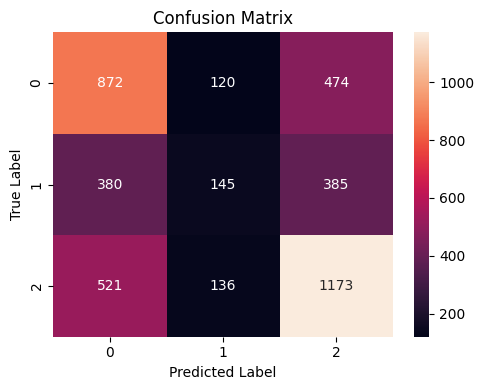

In [37]:
# --- ML Model Training & Evaluation Pipeline ---

# 1. Identify Supertrend change points (potential trade signals)
supertrend_change_mask = df_all['supertrend'] != df_all['supertrend'].shift(1)

# 2. Filter only rows where Supertrend changes (entry/exit points)
df_supertrend_changes = df_all[supertrend_change_mask].copy()
df_supertrend_changes.reset_index(drop=True, inplace=True)

# 3. Time-based Train/Test split (train: <2023, test: >=2023)
df_train = df_supertrend_changes[df_supertrend_changes['time'].dt.year < 2023]
df_test = df_supertrend_changes[df_supertrend_changes['time'].dt.year >= 2023].copy()
df_all_test = df_all[df_all['time'].dt.year >= 2023]

# 4. Prepare features and labels for ML
X_train = df_train.drop(['time', 'label', 'stock_id', 'open'], axis=1, errors='ignore')
y_train = df_train['label']

X_test = df_test.drop(['time', 'label', 'stock_id', 'open'], axis=1, errors='ignore')
y_test = df_test['label']

class_names = ['Short (0)', 'Neutral (1)', 'Long (2)']

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("labels distribution:\n", df_supertrend_changes['label'].value_counts())
print("\n")


# 5. Initialize and configure LightGBM Classifier
model_lgbm = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.01,
    random_state=42,
    max_depth=5,
    num_leaves=24,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1,
    min_child_samples=19,
    verbose=-1
)

# 6. Train the model
model_lgbm.fit(X_train, y_train)

# 7. Predict on test set and evaluate performance
y_pred_lgbm = model_lgbm.predict(X_test)

print(classification_report(y_test, y_pred_lgbm))

# 8. Plot confusion matrix for classification results
cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 9. Store predictions in test DataFrame for further analysis
df_test.loc[:, 'predicted_label'] = y_pred_lgbm

## 10. Feature Importance Analysis

Displays and visualizes the most important features for the LightGBM model.

                       Feature  Importance
87             spx_return_lag2         881
90         slope_ma_6_vix_lag2         797
2                    vix_close         725
14          twitter_total_avg5         716
24                  Volatility         696
0                   spx_return         664
6              news_total_avg5         634
41            volume_zscore_20         610
44             spx_return_lag1         608
23              range_high_low         594
4                news_pos_avg5         588
18        twitter_total_change         584
1               slope_ma_6_spx         578
66         range_high_low_lag1         574
77         OBV_pct_change_lag1         573
88         slope_ma_6_spx_lag2         566
47         slope_ma_6_vix_lag1         563
3               slope_ma_6_vix         562
127      volume_zscore_20_lag2         561
10           news_total_change         560
89              vix_close_lag2         559
45         slope_ma_6_spx_lag1         552
62   twitte

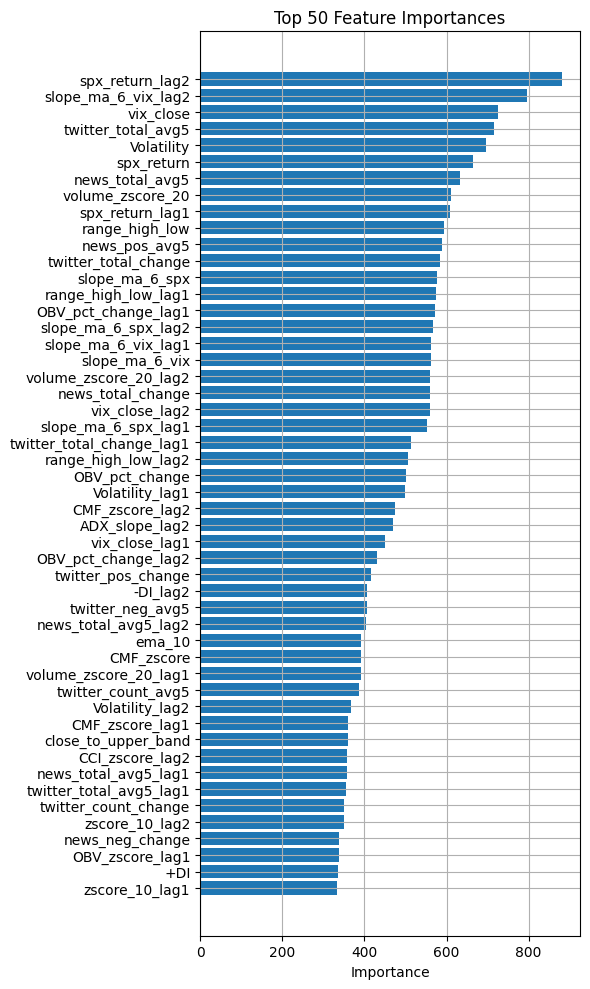

In [38]:
# --- Feature Importance Visualization for LightGBM Model ---

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the top 50 most important features
print(feature_importance_df.head(50))  # Display top 50 features

# Plot the top 50 feature importances as a horizontal bar chart
plt.figure(figsize=(6, 10))
plt.barh(
    feature_importance_df['Feature'][:50][::-1],  # Reverse for descending order
    feature_importance_df['Importance'][:50][::-1]
)
plt.xlabel("Importance")
plt.title("Top 50 Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. ML Prediction Integration

Merges ML predictions into the full test set and forward-fills missing signals for continuous simulation.

In [39]:
# --- Merge ML predictions into full test set and forward-fill missing signals ---

# Merge predicted labels from ML test set into the full test DataFrame.
df_final_display = df_all_test.merge(
    df_test[['time', 'predicted_label', 'stock_id']],
    on=['time', 'stock_id'],
    how='left'
)

df_final_display.loc[0, "predicted_label"] = 1  # Default to 'Neutral' for first row.

# Forward-fill missing predicted labels so every row has a signal.
df_final_display['predicted_label'] = df_final_display['predicted_label'].ffill()

## 12. Signal Visualization

Plots open prices with Supertrend, true labels, and ML-predicted signals for selected stocks.

In [47]:
# --- Visualization of ML and Supertrend signals for each stock ---

max_num_stocks = 0 # change this to plot charts for more stocks

num_stocks = 0

# Group the full test set by stock_id for plotting
for stock_id, df_plot in df_final_display.groupby('stock_id'):
    
    # Limit to first 3 stocks for visualization
    if num_stocks < max_num_stocks:
        print(f"Plotting for stock_id: {stock_id}")

        # Reset index for clean plotting
        df_plot = df_plot.reset_index(drop=True)

        # Extract relevant columns for plotting
        open_prices = df_plot['open']
        predicted_labels = df_plot['predicted_label']
        supertrend_test = df_plot['supertrend']
        trade_result_test = df_plot['label']
        time_plot = df_plot['time']

        # --- Plot 1: Supertrend Buy/Sell Signals ---
        plt.figure(figsize=(15, 3))
        plt.plot(time_plot, open_prices, label='Open Price', color='black')

        # Identify buy/sell signals from Supertrend
        buy_signals = df_plot[supertrend_test == 1].index
        sell_signals = df_plot[supertrend_test == -1].index

        plt.scatter(time_plot.iloc[buy_signals], open_prices.iloc[buy_signals], marker='o', color='green', label='Supertrend Buy', s=30)
        plt.scatter(time_plot.iloc[sell_signals], open_prices.iloc[sell_signals], marker='o', color='red', label='Supertrend Sell', s=30)

        plt.title(f"Stock {stock_id} - Base Indicator Signals")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Plot 2: True Trade Result Labels ---
        plt.figure(figsize=(15, 3))
        plt.plot(time_plot, open_prices, label='Open Price', color='black')

        # Identify buy/sell signals from true labels
        buy_signals = df_plot[(trade_result_test == 2)].index
        sell_signals = df_plot[(trade_result_test == 0)].index

        plt.scatter(time_plot.iloc[buy_signals], open_prices.iloc[buy_signals], marker='o', color='green', label='Label Buy', s=30)
        plt.scatter(time_plot.iloc[sell_signals], open_prices.iloc[sell_signals], marker='o', color='red', label='Label Sell', s=30)

        plt.title(f"Stock {stock_id} - Open Price with Labels")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Plot 3: ML Predicted Buy/Sell Signals ---
        plt.figure(figsize=(15, 3))
        plt.plot(time_plot, open_prices, label='Open Price', color='black')

        # Identify buy/sell signals from ML predictions
        buy_signals = df_plot[(predicted_labels == 2)].index
        sell_signals = df_plot[(predicted_labels == 0)].index

        plt.scatter(time_plot.iloc[buy_signals], open_prices.iloc[buy_signals], marker='o', color='green', label='Predicted Buy', s=40)
        plt.scatter(time_plot.iloc[sell_signals], open_prices.iloc[sell_signals], marker='o', color='red', label='Predicted Sell', s=40)

        plt.title(f"Stock {stock_id} - Open Price with Predicted Signals")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    num_stocks += 1

## 13. Portfolio Simulation with ML Model

Simulates trading using ML signals, calculates PnL, drawdown, Sharpe ratio, and visualizes results.

Stock: AAL
Total PnL: 155.50
Max Drawdown: -42.45
Max Drawdown Date: 2024-04-22 18:30:00
Buy & Hold PnL: -20.21
Win Rate: 60.00%
Number of Trades: 70
Annualized Sharpe: 1.389
Total Fees: 7.00
Last Date: 2025-06-13 19:30:00



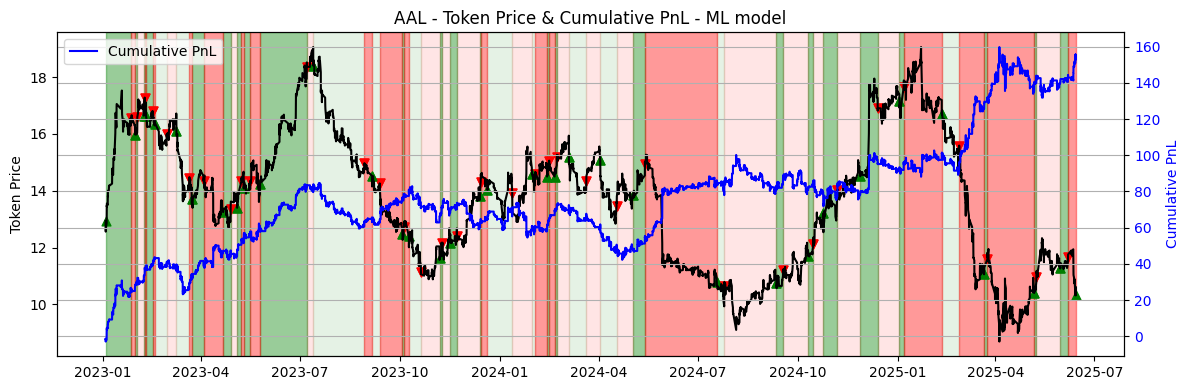

Stock: AAPL
Total PnL: 69.97
Max Drawdown: -21.46
Max Drawdown Date: 2023-11-22 18:30:00
Buy & Hold PnL: 50.58
Win Rate: 57.89%
Number of Trades: 76
Annualized Sharpe: 0.943
Total Fees: 7.60
Last Date: 2025-06-13 19:30:00

Stock: AMD
Total PnL: 225.19
Max Drawdown: -37.42
Max Drawdown Date: 2024-12-20 14:30:00
Buy & Hold PnL: 75.29
Win Rate: 70.53%
Number of Trades: 95
Annualized Sharpe: 1.806
Total Fees: 9.50
Last Date: 2025-06-13 19:30:00

Stock: AMZN
Total PnL: 91.97
Max Drawdown: -34.82
Max Drawdown Date: 2025-04-07 13:30:00
Buy & Hold PnL: 147.54
Win Rate: 65.00%
Number of Trades: 100
Annualized Sharpe: 1.045
Total Fees: 10.00
Last Date: 2025-06-13 19:30:00

Stock: BA
Total PnL: 69.78
Max Drawdown: -51.79
Max Drawdown Date: 2025-05-30 16:30:00
Buy & Hold PnL: 3.32
Win Rate: 67.24%
Number of Trades: 58
Annualized Sharpe: 0.736
Total Fees: 5.80
Last Date: 2025-06-13 19:30:00

Stock: BAC
Total PnL: -22.23
Max Drawdown: -49.65
Max Drawdown Date: 2024-10-15 13:30:00
Buy & Hold PnL: 32.

In [46]:
# --- Portfolio PnL Calculation with ML Model ---
# This block simulates trading for each stock using ML signals (and optionally Supertrend).
# It tracks trades, calculates PnL, drawdown, Sharpe ratio, and visualizes results.

# --- Initialize summary variables ---
total_count = 0                # Number of stocks processed
pnl_all = 0                    # Total PnL across all stocks
buyNhold_pnl_all = 0           # Total buy & hold PnL across all stocks
num_charts = 0                 # Chart counter for plotting
max_num_charts = 1             # max number of stock charts for plotting
is_long_only = False           # If True, disables short trades
total_trades = 0               # Total number of trades
total_winning_trades = 0       # Total number of winning trades
trading_fees = 0.05            # Trading fee (%)
ordersize = 100                # Order size for each trade
is_ml_only = True              # If True, use only ML signals (ignore Supertrend)
max_drawdown_list = []         # List to store max drawdown per stock
initial_capital = 100

# --- Risk-free rate for Sharpe ratio ---
risk_free_annual = 0.04
risk_free_daily = risk_free_annual / 252

stock_pnl_dfs = []             # List to store PnL DataFrames for each stock

# --- Main loop: process each stock ---
for stock_id, df_stock in df_final_display.groupby('stock_id'):
    df_stock = df_stock.reset_index(drop=True)

    # --- Trade tracking variables ---
    position = None            # Current position: 'long', 'short', or None
    entry_price = 0            # Entry price for current position
    entry_price_pnl = 0        # Entry price for PnL calculation
    positions = []             # List to log all trades

    openPrice = 0              # First open price (for buy & hold)
    closePrice = 0             # Last close price (for buy & hold)

    total_count += 1

    # --- Drawdown tracking ---
    max_drawdown = 0
    max_drawdown_time = 0
    drawdown = 0

    # --- PnL tracking ---
    pnl = []                   # List of hourly PnL dicts
    pnl_time = [df_stock['time'].iloc[0]]  # List of timestamps for PnL
    last_pnl_price = 0         # Last price for PnL calculation
    max_pnl = 0                # Maximum cumulative PnL
    current_pnl = 0            # Current cumulative PnL

    # --- Iterate through each row (time step) in the stock DataFrame ---
    for i, row in df_stock.iterrows():
        price = row['open']
        supertrend = row['supertrend']
        predicted_label = row['predicted_label']

        # --- Set open price for buy & hold calculation ---
        if openPrice == 0:
            openPrice = price

        closePrice = price
        fee = 0
        old_position = position

        # --- Entry/Exit Logic ---
        # --- Open Long ---
        if predicted_label == 2 and (supertrend == 1 or is_ml_only):
            if position is None:
                position = 'long'
                entry_price = price
                positions.append({
                    'stock': row['stock_id'],
                    'time': row['time'],
                    'type': 'long',
                    'entry': price,
                    'exit': None,
                    'pnl': None
                })
    
                last_pnl_price = entry_price

            elif position == 'short':
                exit_price = price
                profit = (entry_price - exit_price) * ordersize / entry_price
                fee = ordersize * trading_fees * 2 / 100
                positions[-1]['exit'] = exit_price
                positions[-1]['exit_time'] = row['time']
                positions[-1]['pnl'] = profit - fee

                position = 'long'
                entry_price = price
                positions.append({
                    'stock': row['stock_id'],
                    'time': row['time'],
                    'type': 'long',
                    'entry': price,
                    'exit': None,
                    'pnl': None
                })
    

        # --- Open Short ---
        elif predicted_label == 0 and (supertrend == -1 or is_ml_only):
            if position is None and not is_long_only:
                position = 'short'
                entry_price = price
                positions.append({
                    'stock': row['stock_id'],
                    'time': row['time'],
                    'type': 'short',
                    'entry': price,
                    'exit': None,
                    'pnl': None
                })
    
                last_pnl_price = entry_price

            elif position == 'long':
                exit_price = price
                profit = (exit_price - entry_price) * ordersize / entry_price
                fee = ordersize * trading_fees * 2 / 100
                positions[-1]['exit'] = exit_price
                positions[-1]['exit_time'] = row['time']
                positions[-1]['pnl'] = profit - fee

                if not is_long_only:
                    position = 'short'
                    entry_price = price
                    positions.append({
                        'stock': row['stock_id'],
                        'time': row['time'],
                        'type': 'short',
                        'entry': price,
                        'exit': None,
                        'pnl': None
                    })
                    maxPrice = 0
                    minPrice = 0
                else:
                    position = None

        # --- Close Long Position ---
        elif position == 'long' and (predicted_label == 1 or predicted_label == 0 or (supertrend == -1 and not is_ml_only)):
            exit_price = price
            profit = (exit_price - entry_price) * ordersize / entry_price
            fee = ordersize * trading_fees * 2 / 100
            positions[-1]['exit'] = exit_price
            positions[-1]['exit_time'] = row['time']
            positions[-1]['pnl'] = profit - fee
            position = None

        # --- Close Short Position ---
        elif position == 'short' and (predicted_label == 1 or predicted_label == 2 or (supertrend == 1 and not is_ml_only)):
            exit_price = price
            profit = (entry_price - exit_price) * ordersize / entry_price
            fee = ordersize * trading_fees * 2 / 100
            positions[-1]['exit'] = exit_price
            positions[-1]['exit_time'] = row['time']
            positions[-1]['pnl'] = profit - fee
            position = None

        # --- Hourly PnL Calculation ---
        if old_position == 'long':
            exit_price = price
            entry_price_pnl = last_pnl_price or entry_price
            profit = (exit_price - entry_price_pnl) * ordersize / entry_price_pnl
            pnl.append({'time': row['time'], 'hourly_pnl': profit - fee})
            last_pnl_price = exit_price
            current_pnl += profit - fee

            if current_pnl > max_pnl or max_pnl == 0:
                max_pnl = current_pnl
            if current_pnl < max_pnl:
                drawdown = current_pnl - max_pnl
                if drawdown < max_drawdown:
                    max_drawdown = drawdown
                    max_drawdown_time = row['time']

        elif old_position == 'short':
            exit_price = price
            entry_price_pnl = last_pnl_price or entry_price
            profit = (entry_price_pnl - exit_price) * ordersize / entry_price_pnl
            pnl.append({'time': row['time'], 'hourly_pnl': profit - fee})
            last_pnl_price = exit_price
            current_pnl += profit - fee

            if current_pnl > max_pnl or max_pnl == 0:
                max_pnl = current_pnl
            if current_pnl < max_pnl:
                drawdown = current_pnl - max_pnl
                if drawdown < max_drawdown:
                    max_drawdown = drawdown
                    max_drawdown_time = row['time']

    # --- Final position close at end of data ---
    if position == 'long':
        exit_price = price
        entry_price_pnl = last_pnl_price or entry_price
        profit = (exit_price - entry_price_pnl) * ordersize / entry_price_pnl
        fee = ordersize * trading_fees * 2 / 100
        pnl.append({'time': row['time'], 'hourly_pnl': profit - fee})
        last_pnl_price = exit_price

        # Final trade close
        profit = (exit_price - entry_price) * ordersize / entry_price
        positions[-1]['exit'] = exit_price
        positions[-1]['exit_time'] = row['time']
        positions[-1]['pnl'] = profit - fee
        position = None

        if current_pnl + profit < max_pnl:
            drawdown = current_pnl + profit - max_pnl
            if drawdown < max_drawdown:
                max_drawdown = drawdown
                max_drawdown_time = row['time']

    elif position == 'short':
        exit_price = price
        entry_price_pnl = last_pnl_price or entry_price
        profit = (entry_price_pnl - exit_price) * ordersize / entry_price_pnl
        fee = ordersize * trading_fees * 2 / 100
        pnl.append({'time': row['time'], 'hourly_pnl': profit - fee})
        last_pnl_price = exit_price

        # Final trade close
        profit = (entry_price - exit_price) * ordersize / entry_price
        positions[-1]['exit'] = exit_price
        positions[-1]['exit_time'] = row['time']
        positions[-1]['pnl'] = profit - fee
        position = None

        if current_pnl + profit < max_pnl:
            drawdown = current_pnl + profit - max_pnl
            if drawdown < max_drawdown:
                max_drawdown = drawdown
                max_drawdown_time = row['time']

    # --- Create DataFrames for trades and PnL ---
    trades_df = pd.DataFrame(positions)
    pnl_df = pd.DataFrame(pnl)

    # --- Time conversion for plotting ---
    pnl_df['time'] = pd.to_datetime(pnl_df['time'])
    pnl_df.set_index('time', inplace=True)
    pnl_df['time'] = pnl_df.index

    stock_pnl_dfs.append(pnl_df)

    # --- Return calculations ---
    pnl_df['hourly_return'] = pnl_df['hourly_pnl'] / 100
    pnl_df['gross_return'] = 1 + pnl_df['hourly_return']
    total_return = pnl_df['gross_return'].prod() - 1

    # --- Daily returns and Sharpe ratio ---
    daily_returns = pnl_df['gross_return'].resample('1D').prod(min_count=1) - 1
    excess_daily_returns = daily_returns - risk_free_daily
    mean_daily = excess_daily_returns.mean()
    std_daily = excess_daily_returns.std()
    sharpe = mean_daily / std_daily
    sharpe_annual = sharpe * np.sqrt(252)

    # --- Summary statistics ---
    total_pnl = pnl_df['hourly_pnl'].sum()
    num_trades = len(positions)
    avg_pnl = total_pnl / num_trades if num_trades > 0 else 0
    buynhold = (closePrice - openPrice) * ordersize / openPrice

    pnl_all += total_pnl
    buyNhold_pnl_all += buynhold

    winning_trades = trades_df[trades_df['pnl'] > 0]
    total_winning_trades += len(winning_trades)
    win_rate = (len(winning_trades) / num_trades) * 100 if num_trades > 0 else 0

    # --- Print summary for each stock ---
    print(f"Stock: {stock_id}")
    print(f"Total PnL: {total_pnl:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")
    print(f"Max Drawdown Date: {max_drawdown_time}")
    print(f"Buy & Hold PnL: {buynhold:.2f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Number of Trades: {num_trades}")
    print("Annualized Sharpe:", round(sharpe_annual, 3))
    print(f"Total Fees: {(num_trades * 2 * ordersize * trading_fees / 100):.2f}")
    print(f"Last Date: {df_stock['time'].iloc[-1]}")
    print('')

    total_trades += num_trades
    max_drawdown_list.append(max_drawdown)

    # --- Visualization: plot price, trades, and cumulative PnL ---
    if num_charts < max_num_charts:
        cumulative_pnl = pnl_df['hourly_pnl'].cumsum()
        positions_df = pd.DataFrame(positions)

        # Extract entry/exit for long/short trades
        long_entries = positions_df[positions_df['type'] == 'long']
        long_exits = long_entries[long_entries['exit'].notna()]
        short_entries = positions_df[positions_df['type'] == 'short']
        short_exits = short_entries[short_entries['exit'].notna()]

        fig, ax1 = plt.subplots(figsize=(12, 4))
        ax1.set_title(f"{stock_id} - Token Price & Cumulative PnL - ML model")
        ax1.plot(df_stock['time'], df_stock['open'], color='black', label='Price')
        ax1.set_ylabel('Token Price', color='black')
        ax1.tick_params(axis='y', labelcolor='black')

        # Shade long/short position periods
        for _, row in long_exits.iterrows():
            ax1.axvspan(row['time'], row['exit_time'], color='green',
                        alpha=0.4 if row['pnl'] > 0 else 0.1,
                        label='Active Long Position' if _ == 0 else None)
        for _, row in short_exits.iterrows():
            ax1.axvspan(row['time'], row['exit_time'], color='red',
                        alpha=0.4 if row['pnl'] > 0 else 0.1,
                        label='Active Short Position' if _ == 0 else None)

        ax2 = ax1.twinx()
        ax2.plot(pnl_df['time'], cumulative_pnl, color='blue', label='Cumulative PnL', drawstyle='steps-post')
        ax2.set_ylabel('Cumulative PnL', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        # Plot trade entry/exit markers
        ax1.scatter(long_entries['time'], long_entries['entry'], marker='^', color='green', label='Long Entry', s=40)
        ax1.scatter(long_exits['exit_time'], long_exits['exit'], marker='v', color='red', label='Long Exit', s=40)
        ax1.scatter(short_entries['time'], short_entries['entry'], marker='v', color='red', label='Short Entry', s=40)
        ax1.scatter(short_exits['exit_time'], short_exits['exit'], marker='^', color='green', label='Short Exit', s=40)

        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    num_charts += 1
    
# --- Portfolio summary statistics ---
total_win_rate = (total_winning_trades / total_trades) * 100 if total_trades > 0 else 0

print(f"Total PnL: {pnl_all:.2f}")
print(f"Average PnL: {pnl_all / total_count:.2f}")
print(f"Average Max Drawdown: {sum(max_drawdown_list) / len(max_drawdown_list):.2f}")
print(f"Buy & Hold Average PnL: {buyNhold_pnl_all / total_count:.2f}")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {total_win_rate:.2f}%")

## 14. Portfolio Return Aggregation & Visualization (ML Model)

Aggregates returns across all stocks, plots equity curve and drawdown, and summarizes portfolio statistics.

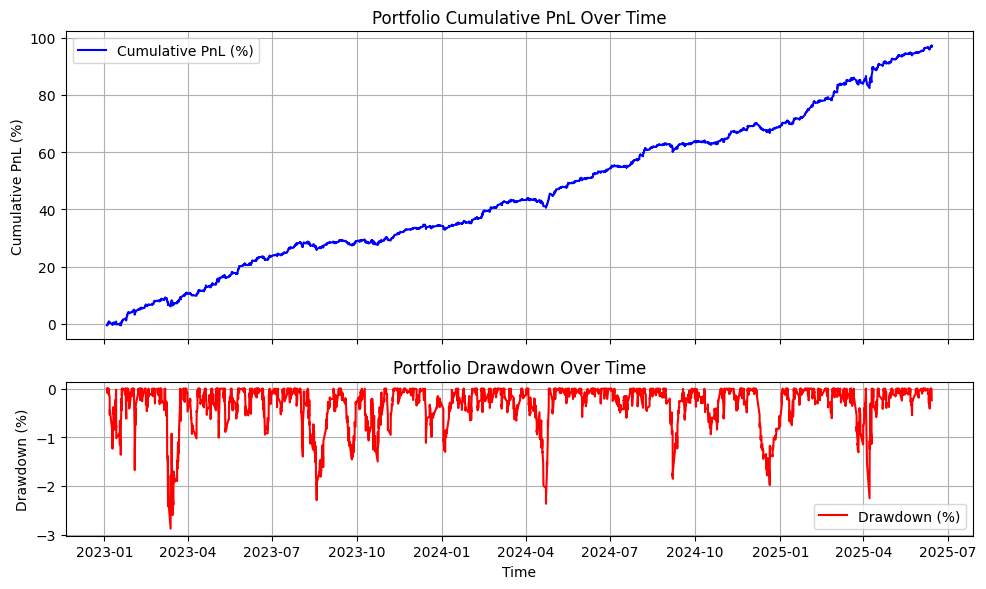

Annualized Sharpe Ratio : 3.585
Maximum Drawdown        : -2.88%
Total Cumulative PnL    : 96.80%


In [42]:
# --- Portfolio-Level PnL Aggregation and Performance Evaluation ---

# Initialize list to hold hourly PnL series for each stock (in %)
stock_returns = []

# Extract and align hourly PnL for each stock
for i, df in enumerate(stock_pnl_dfs):
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.drop_duplicates(subset='time')  # Ensure unique timestamps
    df.set_index('time', inplace=True)

    df[f'pnl_stock_{i}'] = df['hourly_pnl']  # Already in %
    stock_returns.append(df[[f'pnl_stock_{i}']])

# Combine all stock PnL time series into one DataFrame
portfolio_df = pd.concat(stock_returns, axis=1).fillna(0)

# Compute equal-weighted portfolio hourly return (in %) 
portfolio_df['portfolio_hourly_return'] = portfolio_df.mean(axis=1) 

# Calculate cumulative PnL over time (in %) 
portfolio_df['cumulative_pnl_percent'] = portfolio_df['portfolio_hourly_return'].cumsum()

# -- Calculate daily returns and Sharpe ratio --
# Convert hourly returns to gross returns for compounding
portfolio_df['gross_return'] = 1 + portfolio_df['portfolio_hourly_return'] / 100

# Resample to daily gross returns and compute daily return
daily_returns = portfolio_df['gross_return'].resample('1D').prod() - 1

# Excess return over risk-free rate (daily)
excess_daily_returns = daily_returns - risk_free_daily
mean_excess = excess_daily_returns.mean()
std_excess = excess_daily_returns.std()

# Daily and annualized Sharpe ratio
sharpe_daily = mean_excess / std_excess
sharpe_annual = sharpe_daily * np.sqrt(252)

# Compute drawdown from cumulative PnL 
# Start from 100 to simulate a normalized capital base
cumulative = portfolio_df['cumulative_pnl_percent'] + 100
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
portfolio_df['drawdown'] = drawdown
max_drawdown = drawdown.min()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot equity curve
axes[0].plot(portfolio_df.index, portfolio_df['cumulative_pnl_percent'], color='blue', label='Cumulative PnL (%)')
axes[0].set_title("Portfolio Cumulative PnL Over Time")
axes[0].set_ylabel("Cumulative PnL (%)")
axes[0].legend()
axes[0].grid(True)

# Plot drawdown
axes[1].plot(portfolio_df.index, portfolio_df['drawdown'] * 100, color='red', label='Drawdown (%)')
axes[1].set_title("Portfolio Drawdown Over Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Drawdown (%)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print performance summary 
final_pnl = portfolio_df['cumulative_pnl_percent'].iloc[-1]

print(f"Annualized Sharpe Ratio : {sharpe_annual:.3f}")
print(f"Maximum Drawdown        : {max_drawdown * 100:.2f}%")
print(f"Total Cumulative PnL    : {final_pnl:.2f}%")

## 15. Portfolio Simulation with Supertrend Indicator

Simulates trading using only Supertrend signals, calculates PnL, drawdown, Sharpe ratio, and visualizes results.

Stock: AAL
Total PnL: 34.27
Max Drawdown: -42.57
Max Drawdown Date: 2023-11-30 15:30:00
Buy & Hold PnL: -20.21
Win Rate: 39.84%
Number of Trades: 128
Annualized Sharpe: 0.165
Total Fees: 12.80
Last Date: 2025-06-13 19:30:00



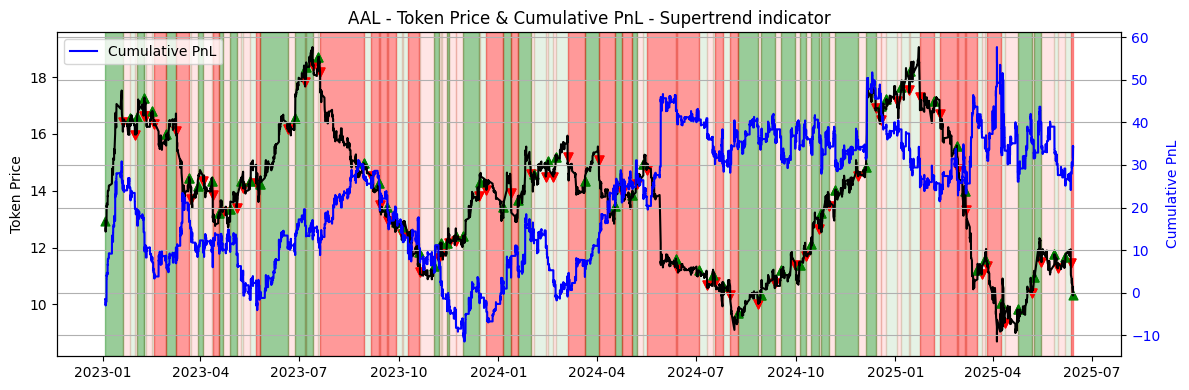

Stock: AAPL
Total PnL: -13.03
Max Drawdown: -60.23
Max Drawdown Date: 2024-11-25 17:30:00
Buy & Hold PnL: 50.58
Win Rate: 42.52%
Number of Trades: 127
Annualized Sharpe: -0.363
Total Fees: 12.70
Last Date: 2025-06-13 19:30:00

Stock: AMD
Total PnL: -61.01
Max Drawdown: -90.33
Max Drawdown Date: 2024-07-03 14:30:00
Buy & Hold PnL: 75.29
Win Rate: 32.88%
Number of Trades: 146
Annualized Sharpe: -0.546
Total Fees: 14.60
Last Date: 2025-06-13 19:30:00

Stock: AMZN
Total PnL: -54.08
Max Drawdown: -75.60
Max Drawdown Date: 2025-04-17 13:30:00
Buy & Hold PnL: 147.54
Win Rate: 39.55%
Number of Trades: 134
Annualized Sharpe: -0.75
Total Fees: 13.40
Last Date: 2025-06-13 19:30:00

Stock: BA
Total PnL: 81.07
Max Drawdown: -55.18
Max Drawdown Date: 2024-11-08 19:30:00
Buy & Hold PnL: 3.32
Win Rate: 40.68%
Number of Trades: 118
Annualized Sharpe: 0.68
Total Fees: 11.80
Last Date: 2025-06-13 19:30:00

Stock: BAC
Total PnL: 75.72
Max Drawdown: -33.55
Max Drawdown Date: 2025-04-10 16:30:00
Buy & Hold 

In [45]:
# --- Portfolio PnL Calculation using Supertrend indicator only ---
# This block simulates trading for each stock using only Supertrend signals.
# It tracks trades, calculates PnL, drawdown, Sharpe ratio, and visualizes results.

# === Initialize summary variables ===
total_count = 0                # Number of stocks processed
pnl_all = 0                    # Total PnL across all stocks
buyNhold_pnl_all = 0           # Total buy & hold PnL across all stocks
num_charts = 0                 # Chart counter for plotting
max_num_charts = 1            # max number of stock charts for plotting
is_long_only = False           # If True, disables short trades
total_trades = 0               # Total number of trades
total_winning_trades = 0       # Total number of winning trades
trading_fees = 0.05            # Trading fee (%)
ordersize = 100                # Order size for each trade
max_drawdown_list = []         # List to store max drawdown per stock

# === Risk-free rate for Sharpe ratio ===
risk_free_annual = 0.04
risk_free_daily = risk_free_annual / 252

stock_pnl_dfs_2 = []             # List to store PnL DataFrames for each stock

# === Main loop: process each stock ===
for stock_id, df_stock in df_final_display.groupby('stock_id'):
    df_stock = df_stock.reset_index(drop=True)

    # --- Trade tracking variables ---
    position = None            # Current position: 'long', 'short', or None
    entry_price = 0            # Entry price for current position
    entry_price_pnl = 0        # Entry price for PnL calculation
    positions = []             # List to log all trades

    openPrice = 0              # First open price (for buy & hold)
    closePrice = 0             # Last close price (for buy & hold)

    total_count += 1

    # --- Drawdown tracking ---
    max_drawdown = 0
    max_drawdown_time = 0
    drawdown = 0

    # --- PnL tracking ---
    pnl = []                   # List of hourly PnL dicts
    pnl_time = [df_stock['time'].iloc[0]]  # List of timestamps for PnL
    last_pnl_price = 0         # Last price for PnL calculation
    max_pnl = 0                # Maximum cumulative PnL
    current_pnl = 0            # Current cumulative PnL


    # --- Iterate through each row (time step) in the stock DataFrame ---
    for i, row in df_stock.iterrows():
        price = row['open']
        supertrend = row['supertrend']
        predicted_label = row['predicted_label']

        # --- Set open price for buy & hold calculation ---
        if openPrice == 0:
            openPrice = price

        closePrice = price
        fee = 0
        old_position = position

        # --- Entry/Exit Logic ---
        # --- Open Long ---
        if supertrend == 1:
            if position is None:
                position = 'long'
                entry_price = price
                positions.append({
                    'stock': row['stock_id'],
                    'time': row['time'],
                    'type': 'long',
                    'entry': price,
                    'exit': None,
                    'pnl': None
                })
                last_pnl_price = entry_price

            elif position == 'short':
                exit_price = price
                profit = (entry_price - exit_price) * ordersize / entry_price
                fee = ordersize * trading_fees * 2 / 100
                positions[-1]['exit'] = exit_price
                positions[-1]['exit_time'] = row['time']
                positions[-1]['pnl'] = profit - fee

                position = 'long'
                entry_price = price
                positions.append({
                    'stock': row['stock_id'],
                    'time': row['time'],
                    'type': 'long',
                    'entry': price,
                    'exit': None,
                    'pnl': None
                })

        # --- Open Short ---
        elif supertrend == -1:
            if position is None and not is_long_only:
                position = 'short'
                entry_price = price
                positions.append({
                    'stock': row['stock_id'],
                    'time': row['time'],
                    'type': 'short',
                    'entry': price,
                    'exit': None,
                    'pnl': None
                })
                last_pnl_price = entry_price

            elif position == 'long':
                exit_price = price
                profit = (exit_price - entry_price) * ordersize / entry_price
                fee = ordersize * trading_fees * 2 / 100
                positions[-1]['exit'] = exit_price
                positions[-1]['exit_time'] = row['time']
                positions[-1]['pnl'] = profit - fee

                if not is_long_only:
                    position = 'short'
                    entry_price = price
                    positions.append({
                        'stock': row['stock_id'],
                        'time': row['time'],
                        'type': 'short',
                        'entry': price,
                        'exit': None,
                        'pnl': None
                    })
                    maxPrice = 0
                    minPrice = 0
                else:
                    position = None

        # --- Hourly PnL Calculation ---
        if old_position == 'long':
            exit_price = price
            entry_price_pnl = last_pnl_price or entry_price
            profit = (exit_price - entry_price_pnl) * ordersize / entry_price_pnl
            pnl.append({'time': row['time'], 'hourly_pnl': profit - fee})
            last_pnl_price = exit_price
            current_pnl += profit - fee

            if current_pnl > max_pnl or max_pnl == 0:
                max_pnl = current_pnl
            if current_pnl < max_pnl:
                drawdown = current_pnl - max_pnl
                if drawdown < max_drawdown:
                    max_drawdown = drawdown
                    max_drawdown_time = row['time']

        elif old_position == 'short':
            exit_price = price
            entry_price_pnl = last_pnl_price or entry_price
            profit = (entry_price_pnl - exit_price) * ordersize / entry_price_pnl
            pnl.append({'time': row['time'], 'hourly_pnl': profit - fee})
            last_pnl_price = exit_price
            current_pnl += profit - fee

            if current_pnl > max_pnl or max_pnl == 0:
                max_pnl = current_pnl
            if current_pnl < max_pnl:
                drawdown = current_pnl - max_pnl
                if drawdown < max_drawdown:
                    max_drawdown = drawdown
                    max_drawdown_time = row['time']

    # --- Final position close at end of data ---
    if position == 'long':
        exit_price = price
        entry_price_pnl = last_pnl_price or entry_price
        profit = (exit_price - entry_price_pnl) * ordersize / entry_price_pnl
        fee = ordersize * trading_fees * 2 / 100
        pnl.append({'time': row['time'], 'hourly_pnl': profit - fee})
        last_pnl_price = exit_price

        # --- Close open position for summary stats ---
        profit = (exit_price - entry_price) * ordersize / entry_price
        positions[-1]['exit'] = exit_price
        positions[-1]['exit_time'] = row['time']
        positions[-1]['pnl'] = profit - fee
        position = None

        if current_pnl + profit < max_pnl:
            drawdown = current_pnl + profit - max_pnl
            if drawdown < max_drawdown:
                max_drawdown = drawdown
                max_drawdown_time = row['time']

    elif position == 'short':
        exit_price = price
        entry_price_pnl = last_pnl_price or entry_price
        profit = (entry_price_pnl - exit_price) * ordersize / entry_price_pnl
        fee = ordersize * trading_fees * 2 / 100
        pnl.append({'time': row['time'], 'hourly_pnl': profit - fee})
        last_pnl_price = exit_price

        # --- Close open position for summary stats ---
        profit = (entry_price - exit_price) * ordersize / entry_price
        positions[-1]['exit'] = exit_price
        positions[-1]['exit_time'] = row['time']
        positions[-1]['pnl'] = profit - fee
        position = None

        if current_pnl + profit < max_pnl:
            drawdown = current_pnl + profit - max_pnl
            if drawdown < max_drawdown:
                max_drawdown = drawdown
                max_drawdown_time = row['time']
        

    # --- Create DataFrames for trades and PnL ---
    trades_df = pd.DataFrame(positions)
    pnl_df = pd.DataFrame(pnl)

    # --- Time conversion for plotting ---
    pnl_df['time'] = pd.to_datetime(pnl_df['time'])
    pnl_df.set_index('time', inplace=True)
    pnl_df['time'] = pnl_df.index

    stock_pnl_dfs_2.append(pnl_df)

    # --- Return calculations ---
    pnl_df['hourly_return'] = pnl_df['hourly_pnl'] / 100
    pnl_df['gross_return'] = 1 + pnl_df['hourly_return']
    total_return = pnl_df['gross_return'].prod() - 1

    # --- Daily returns and Sharpe ratio ---
    daily_returns = pnl_df['gross_return'].resample('1D').prod() - 1
    excess_daily_returns = daily_returns - risk_free_daily
    mean_daily = excess_daily_returns.mean()
    std_daily = excess_daily_returns.std()
    sharpe = mean_daily / std_daily
    sharpe_annual = sharpe * np.sqrt(252)

    # --- Summary statistics ---
    total_pnl = pnl_df['hourly_pnl'].sum()
    num_trades = len(positions)
    avg_pnl = total_pnl / num_trades if num_trades > 0 else 0
    buynhold = (closePrice - openPrice) * ordersize / openPrice

    pnl_all += total_pnl
    buyNhold_pnl_all += buynhold

    winning_trades = trades_df[trades_df['pnl'] > 0]
    total_winning_trades += len(winning_trades)
    win_rate = (len(winning_trades) / num_trades) * 100 if num_trades > 0 else 0

    # --- Print summary for each stock ---
    print(f"Stock: {stock_id}")
    print(f"Total PnL: {total_pnl:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")
    print(f"Max Drawdown Date: {max_drawdown_time}")
    print(f"Buy & Hold PnL: {buynhold:.2f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Number of Trades: {num_trades}")
    print("Annualized Sharpe:", round(sharpe_annual, 3))
    print(f"Total Fees: {(num_trades * 2 * ordersize * trading_fees / 100):.2f}")
    print(f"Last Date: {df_stock['time'].iloc[-1]}")
    print('')

    
    total_trades += num_trades
    max_drawdown_list.append(max_drawdown)

    # --- Visualization: plot price, trades, and cumulative PnL ---
    if num_charts < max_num_charts:
        cumulative_pnl = pnl_df['hourly_pnl'].cumsum()
        positions_df = pd.DataFrame(positions)

        # Extract entry/exit for long/short trades
        long_entries = positions_df[positions_df['type'] == 'long']
        long_exits = long_entries[long_entries['exit'].notna()]
        short_entries = positions_df[positions_df['type'] == 'short']
        short_exits = short_entries[short_entries['exit'].notna()]

        fig, ax1 = plt.subplots(figsize=(12, 4))
        ax1.set_title(f"{stock_id} - Token Price & Cumulative PnL - Supertrend indicator")
        ax1.plot(df_stock['time'], df_stock['open'], color='black', label='Price')
        ax1.set_ylabel('Token Price', color='black')
        ax1.tick_params(axis='y', labelcolor='black')

        # Shade long/short position periods
        for _, row in long_exits.iterrows():
            ax1.axvspan(row['time'], row['exit_time'], color='green',
                        alpha=0.4 if row['pnl'] > 0 else 0.1,
                        label='Active Long Position' if _ == 0 else None)
        for _, row in short_exits.iterrows():
            ax1.axvspan(row['time'], row['exit_time'], color='red',
                        alpha=0.4 if row['pnl'] > 0 else 0.1,
                        label='Active Short Position' if _ == 0 else None)

        ax2 = ax1.twinx()
        ax2.plot(pnl_df['time'], cumulative_pnl, color='blue', label='Cumulative PnL', drawstyle='steps-post')
        ax2.set_ylabel('Cumulative PnL', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        # Plot trade entry/exit markers
        ax1.scatter(long_entries['time'], long_entries['entry'], marker='^', color='green', label='Long Entry', s=40)
        ax1.scatter(long_exits['exit_time'], long_exits['exit'], marker='v', color='red', label='Long Exit', s=40)
        ax1.scatter(short_entries['time'], short_entries['entry'], marker='v', color='red', label='Short Entry', s=40)
        ax1.scatter(short_exits['exit_time'], short_exits['exit'], marker='^', color='green', label='Short Exit', s=40)

        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    num_charts += 1
    
# --- Portfolio summary statistics ---
total_win_rate = (total_winning_trades / total_trades) * 100 if total_trades > 0 else 0

print(f"Total PnL: {pnl_all:.2f}")
print(f"Average PnL: {pnl_all / total_count:.2f}")
print(f"Average Max Drawdown: {sum(max_drawdown_list) / len(max_drawdown_list):.2f}")
print(f"Buy & Hold Average PnL: {buyNhold_pnl_all / total_count:.2f}")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {total_win_rate:.2f}%")

## 16. Portfolio Return Aggregation & Visualization (Supertrend Only)

Aggregates returns across all stocks, plots equity curve and drawdown, and summarizes portfolio statistics.

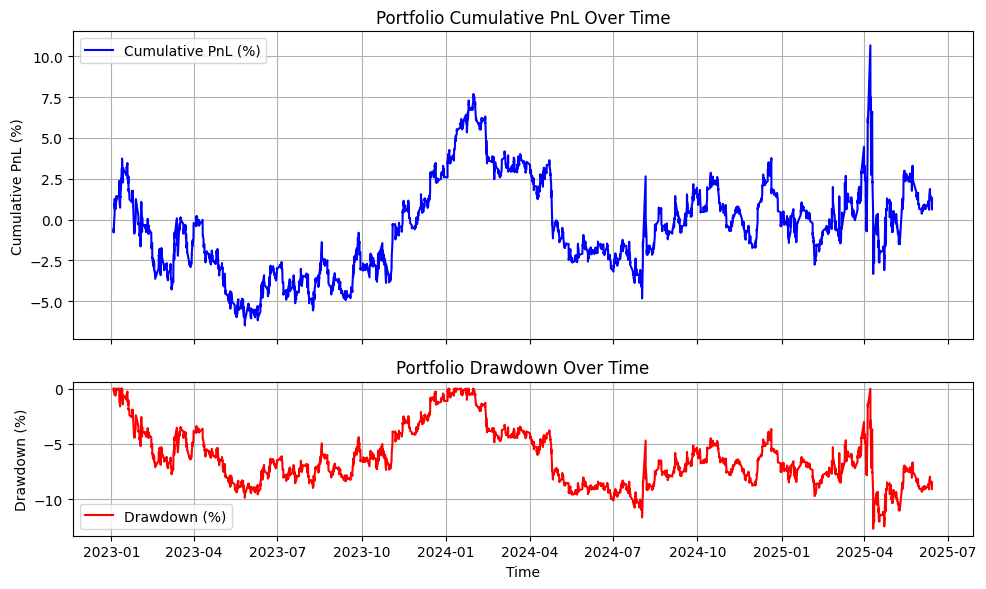

Annualized Sharpe Ratio : -0.411
Maximum Drawdown        : -12.66%
Total Cumulative PnL    : 1.28%


In [44]:
# --- Portfolio-Level PnL Aggregation and Performance Evaluation ---

# Initialize list to hold hourly PnL series for each stock (in %)
stock_returns = []

# Extract and align hourly PnL for each stock
for i, df in enumerate(stock_pnl_dfs_2):
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.drop_duplicates(subset='time')  # Ensure unique timestamps
    df.set_index('time', inplace=True)

    df[f'pnl_stock_{i}'] = df['hourly_pnl']  # Already in %
    stock_returns.append(df[[f'pnl_stock_{i}']])

# Combine all stock PnL time series into one DataFrame
portfolio_df = pd.concat(stock_returns, axis=1).fillna(0)

# Compute equal-weighted portfolio hourly return (in %) 
portfolio_df['portfolio_hourly_return'] = portfolio_df.mean(axis=1) 

# Calculate cumulative PnL over time (in %) 
portfolio_df['cumulative_pnl_percent'] = portfolio_df['portfolio_hourly_return'].cumsum()

# -- Calculate daily returns and Sharpe ratio --
# Convert hourly returns to gross returns for compounding
portfolio_df['gross_return'] = 1 + portfolio_df['portfolio_hourly_return'] / 100

# Resample to daily gross returns and compute daily return
daily_returns = portfolio_df['gross_return'].resample('1D').prod() - 1

# Excess return over risk-free rate (daily)
excess_daily_returns = daily_returns - risk_free_daily
mean_excess = excess_daily_returns.mean()
std_excess = excess_daily_returns.std()

# Daily and annualized Sharpe ratio
sharpe_daily = mean_excess / std_excess
sharpe_annual = sharpe_daily * np.sqrt(252)

# Compute drawdown from cumulative PnL 
# Start from 100 to simulate a normalized capital base
cumulative = portfolio_df['cumulative_pnl_percent'] + 100
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
portfolio_df['drawdown'] = drawdown
max_drawdown = drawdown.min()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot equity curve
axes[0].plot(portfolio_df.index, portfolio_df['cumulative_pnl_percent'], color='blue', label='Cumulative PnL (%)')
axes[0].set_title("Portfolio Cumulative PnL Over Time")
axes[0].set_ylabel("Cumulative PnL (%)")
axes[0].legend()
axes[0].grid(True)

# Plot drawdown
axes[1].plot(portfolio_df.index, portfolio_df['drawdown'] * 100, color='red', label='Drawdown (%)')
axes[1].set_title("Portfolio Drawdown Over Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Drawdown (%)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print performance summary 
final_pnl = portfolio_df['cumulative_pnl_percent'].iloc[-1]

print(f"Annualized Sharpe Ratio : {sharpe_annual:.3f}")
print(f"Maximum Drawdown        : {max_drawdown * 100:.2f}%")
print(f"Total Cumulative PnL    : {final_pnl:.2f}%")